# **FINM 33150 | Quant Trading Project Draft**

### Team:
- Stephen Coley (12457982)
- Harrison Holt (12365286)
- Josh Li (12241827)
- Kyle Parran (12406685)

### Latest Version: Mar-01-2025

## The Task

The end goal here is to invent, simulate, and analyze a quantitative trading strategy.

Our initial ideas for a strategy include:


Once we determine a viable strategy we will need to ensure such a strategy has the following features:
- Investment in publicly traded (but not necessarily electronically traded) assets
- A "recipe" for evaluating attractiveness of potential trades that
    - depend on pre-specified classes of info
    - could be followed by anyone, given the recipe and data sources
- A "recipe" for investment sizes, and position entry and exit rules, that
    - may link position size to attractiveness
    - ensures risk stays within limits and capital remains bounded
    - makes reasonable assumptions about entry and exit liquidity

Elements of trading strategies include lead-lag relationships, market making, carry trades, pair trading, factor investment, model reversion, merger arbitrage, technical signals, etc.

Our strategy should have the following features:
- Significant dependence on at least one class of information that is not twitter, equity ohlc, equity VWAPs, or equity trading volumes, unelss at a relatively high frequency (600 secs or less)
- As of at least some times in your simulation, simultaneously holds at least 5 distinct assets (different currencies, commodities, option maturities/strikes etc.)
- Produces a total of 40 trades or more over your entire analysis/simulation period, without excessive clustering
- Leverage, with documented and reasonable capital and risk control assumptions


## **Outline**

### 1. Introduction

### 2. Data Assembly

### 3. Data Analysis

--------Next Phase--------

### 4. Strategy Implementation

### 6. Backtesting

### 7. Performance Analysis

### 8. References

## **Introduction**

### **Strategy Overview**
The objective of this strategy is to develop a quantile-based trading model that ranks equities based on their expected price drift following an earnings surprise announcement. The expected drift is estimated by comparing the earnings surprise percentage for each quarter with the next-day price movement of that equity. The assumption is that the smaller the price reaction relative to the earnings surprise, the more post-earnings drift there is to capture. 

To standardize this metric, we will z-score the "surprise vs. price move" metric within bins based on average EPS size to control for the effects of large versus small earnings surprises. To enhance diversification, additional fundamental and technical indicators related to growth and momentum will also be incorporated, each standardized through z-scoring within their respective bins. 

Initially, the "surprise vs. price move" metric will be weighted more heavilym as it forms the core of our thesis, with the flexibility to adjust the weights of other indicators based on observed results. Further details on data collection, execution methodology, and risk/liquidity constraints are outlined below.

### **Data Acquisition**
- **EPS Actual Data and Consensus Estimates/Surprise Metrics** from WRDS I/B/E/S
- **Equity Close Prices** from NASDAQ's 'QUOTEMEDIA/PRICES' dataset
- **Fundamental and Market Value Data** from NASDAQ's ZACKS Fundamental B dataset
- **Execution Data** from WRDS BARS dataset

### **Additional Constraints/Specifications**
- **Long/Short Quantile Approach:** To minimize risk, we implement a market-neutral long/short quantile approach.
- **Stop-Loss Protection:** Each stock position will have a 10% stop-loss limit to mitigate downside risk.
- **Position Sizing:**
  - No single stock will exceed 5% of total portfolio value.
  - We will allocate larger position sizes to the higher-ranked quantile equities within our strategy's framework.
- **Liquidity Constraints:** The investable universe is limited to stocks with market capitalization > $500M, ensuring sufficient liquidity.
- **Leverage & Capital Structure:**
  - We will set initial capital as 10x gross notional of the first month’s set of positions.
  - Net value of long and short positions will determine the capital allocation at each rebalance.
  - Securities will be easy to borrow, with a repo rate equal to the funding rate minus 100bps:
    
    $$repo\ rate = funding\ rate - 0.01$$
    
  - A constant funding rate of 4.30% (approximate 3-month SOFR rate) is assumed for ease of calculations.
  - The total invested capital is calculated as:
    
   $$\sum(adjusted\ prices_i*positions_i) * 10 $$

- **Capital Adjustment:** At each rebalance/lookback period, we will adjust capital based on both realized and unrealized PnL while maintaining the 10x leverage structure throughout the lifecycle of the strategy.

### **Constraints/Parameters to Test and Optimize**

**1. Quantile Size (q)**
- The number of quantiles (e.g., 5, 10) will be tested to optimize trade selection.
- Within each quantile, equities will not be equally weighted; instead, we will assign higher weights to better-ranked equities and lower weights to weaker-ranked equities.

**2. Lookback Period (L)**
- We will evaluate different lookback periods, comparing a static 3-month rebalancing strategy with a more dynamic shorter-period rebalancing approach:
  - **3-Month Approach:** Portfolio holdings will be adjusted every quarter based on the latest earnings surprise and fundamental rankings.
  - **Shorter Lookback Periods:**
    - A rolling ranking system will be used, where equities are added as earnings are announced.
    - Re-evaluations will take place after each L-period, ensuring rankings and portfolio holdings remain responsive to new earnings data.

By systematically testing these parameters, we aim to fine-tune the trading strategy to optimize risk-adjusted returns while ensuring efficient execution and capital allocation.

## **Setup**

In [21]:
import pandas as pd
import numpy as np
import nasdaqdatalink as ndl
import quandl
import wrds
from dotenv import load_dotenv
import os
import datetime
from datetime import timedelta
from plotnine import ggplot, aes, geom_line, scale_color_manual, geom_hline, labs, theme, element_text, facet_wrap, geom_histogram, ggtitle, geom_boxplot, stat_function, geom_density
from scipy.stats import norm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import warnings
from mpl_toolkits.mplot3d import Axes3D
import functools
from scipy.stats import zscore
from sklearn.decomposition import PCA
from functools import lru_cache
import pytz

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

load_dotenv()

ndl.ApiConfig.api_key = os.getenv('NDL_API_KEY')
quandl_api_key = os.getenv('NDL_API_KEY')
wrds_username = os.getenv('WRDS_USERNAME')
adv_api_key = os.getenv('ADV_API_KEY')

db = wrds.Connection(wrds_username=wrds_username, verbose = False)

Loading library list...
Done


## **Data Assembly**

### Quandl function

In [23]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.path.expanduser("~"), "quandl_data_table_downloads")
    if not os.path.exists(root_data_dir):
        print(f"Directory does not exist. Creating: {root_data_dir}")
        os.makedirs(root_data_dir, exist_ok=True)
    else:
        print(f"Directory already exists: {root_data_dir}")

    data_symlink = os.path.normpath(os.path.join(root_data_dir, f"{table_path}_latest.zip"))

    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)

    print(table_dir)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.normpath(os.path.join(root_data_dir, f"{table_path}_{my_date}.zip"))

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, 
        filename=data_file, 
        api_key=os.getenv('NDL_API_KEY'), 
        **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        print(data_symlink)
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

### Data load

#### **Zacks Fundamental B**

| Table                       | Table Code   | Table Description                                                                                                                                                                                                                                                                   |
|-----------------------------|--------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Fundamentals Condensed      | ZACKS/FC     | This table contains over 200 fundamental indicators for over 19,500 companies including over 10,000 delisted stocks. For access to additional indicators see Zacks Fundamentals C.                                                                                                    |
| Fundamentals Ratios         | ZACKS/FR     | This table contains 26 fundamental ratios for over 19,500 companies, including over 10,000 delisted stocks.                                                                                                                                                                           |
| Master Table                | ZACKS/MT     | This table contains descriptive information about all tickers that are included in Zacks products.                                                                                                                                                                                   |
| Market Value Supplement     | ZACKS/MKTV   | This table contains supplementary information to Zacks fundamentals, with updated values for market capitalization and enterprise value. Market cap is the total value of all of a company's outstanding stock. You calculate it by multiplying the current stock price by the number of shares owned by stockholders. |
| Shares Out Supplement       | ZACKS/SHRS   | This table contains supplementary information to Zacks fundamentals, with updated values for common shares outstanding and average diluted shares outstanding. Shares outstanding are the total number of shares issued by a corporation.                                              |
| Historical Daily Maintenance| ZACKS/HDM    | This table offers historical daily corporate actions for over 7,000 U.S. and Canadian listed companies. Sometimes the price of a stock changes because of events that are not associated with the supply-and-demand forces of the markets. For instance, if a company declares a stock split or reverse stock split, the share price will change radically, even though it does not actually affect the value of the company or investors' holdings in the stock. The adjusted close price shows the effect of these events. |

In [90]:
start_filing_date = '2014-01-01'
end_filing_date = '2024-12-31'
start_filter_date = '2019-01-01'
end_filter_date = '2024-12-31'

year_beginning_filing = pd.to_datetime(start_filing_date).year
year_end_filing = pd.to_datetime(end_filing_date).year

year_beginning_filter = pd.to_datetime(start_filter_date).year
year_end_filter = pd.to_datetime(end_filter_date).year

zacks_fc = fetch_quandl_table('ZACKS/FC', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_fr = fetch_quandl_table('ZACKS/FR', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_mt = fetch_quandl_table('ZACKS/MT', avoid_download=True)
zacks_mktv = fetch_quandl_table('ZACKS/MKTV', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_shrs = fetch_quandl_table('ZACKS/SHRS', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_hdm = fetch_quandl_table('ZACKS/HDM', avoid_download=True)

zacks_fc['per_end_date'] = pd.to_datetime(zacks_fc['per_end_date'])
zacks_fc['filing_date'] = pd.to_datetime(zacks_fc['filing_date'])+timedelta(days=1)
zacks_fr['per_end_date'] = pd.to_datetime(zacks_fr['per_end_date'])
zacks_mktv['per_end_date'] = pd.to_datetime(zacks_mktv['per_end_date'])
zacks_shrs['per_end_date'] = pd.to_datetime(zacks_shrs['per_end_date'])
zacks_fc = zacks_fc.dropna(subset=['per_end_date', 'filing_date'])

zacks_df = pd.merge(zacks_fc, zacks_fr, on=['ticker', 'per_end_date', 'per_type'], how='left', suffixes=('_fc', '_fr'))
zacks_df = pd.merge(zacks_df, zacks_mktv, on=['ticker', 'per_end_date', 'per_type'], how='left')
zacks_df = pd.merge(zacks_df, zacks_shrs, on=['ticker', 'per_end_date', 'per_type'], how='left')
zacks_df = pd.merge(zacks_df, zacks_mt, on=['ticker'], how='left')

In order to avoid issues with illiquid stocks and ensure ample market reaction to earnings we apply a filter criteria when creating our company universe. Based on Zacks Fundamentals, we limited our company universe to firms with greater than a $500 million market value threshold. 

In [26]:
top_stocks = zacks_mktv.loc[(zacks_mktv['per_end_date'] == zacks_mktv.per_end_date.max()) & (zacks_mktv['mkt_val']>=500)].sort_values(by='mkt_val', ascending=False).copy().reset_index(drop=True)
top_tickers = tuple(top_stocks.ticker)
top_tickers_list = list(top_tickers)

print(f"{len(top_tickers):,} tickers with market cap >= 500M")

3,196 tickers with market cap >= 500M


#### **Quandl EOD price data**

When referencing price end of day price data we will utilize Quandl End of Day US Stock Prices. Updated daily, this data feed offers end of day prices, dividends, adjustments and splits for U.S. publicly traded stocks with history to 1996. Prices are provided both adjusted and unadjusted.

Key Features:

- Covers all stocks with primary listing on NASDAQ, AMEX, NYSE and ARCA.
- Includes unadjusted and adjusted open, high, low, close, volume.
- Includes dividend history and split history.
- Updated at or before 5:00 pm ET on all trading days.
- Exchange corrections are applied by 9:30 pm ET.
- Historical data goes back to 1996.

In [ ]:
eod_data = fetch_quandl_table(
    'QUOTEMEDIA/PRICES', 
    avoid_download=True,
)

spy_eod_data =  eod_data.loc[
                            (eod_data.ticker.isin(['SPY']))
                            & (eod_data.date >= '2014-01-01')
                            & (eod_data.date <= '2024-12-31')
                        ].copy()

spy_eod_data = spy_eod_data.sort_values(['ticker', 'date'], ascending=[True, True]).reset_index(drop=True)

spy_eod_data.to_parquet('../data/spy_eod_data_2014_2024.parquet')
spy_eod_data = pd.read_parquet('../data/spy_eod_data_2014_2024.parquet')

top_eod_data = eod_data.loc[
                            (eod_data.ticker.isin(top_tickers_list))
                            & (eod_data.date >= '2014-01-01')
                            & (eod_data.date <= '2024-12-31')
                        ].copy()

top_eod_data = top_eod_data.sort_values(['ticker', 'date'], ascending=[True, True]).reset_index(drop=True)

top_eod_data.to_parquet('../data/top_eod_data_2014_2024.parquet')
top_eod_data = pd.read_parquet('../data/top_eod_data_2014_2024.parquet')

top_eod_data['daily_rets'] = top_eod_data.groupby('ticker')['adj_close'].pct_change()

display(top_eod_data.head())
display(top_eod_data.tail())

,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,returns,daily_rets
0,A,2014-01-02,57.10,57.100,56.15,56.21,1916200.0,0.0,1.0,37.731086,37.731086,37.103336,37.142983,1916200.0,NaN,NaN
1,A,2014-01-03,56.39,57.345,56.26,56.92,1866700.0,0.0,1.0,37.261925,37.892979,37.176023,37.612144,1866700.0,0.012631,0.012631
2,A,2014-01-06,57.40,57.700,56.56,56.64,1777300.0,0.0,1.0,37.929323,38.127560,37.374259,37.427123,1777300.0,-0.004919,-0.004919
3,A,2014-01-07,56.95,57.630,56.93,57.45,1463200.0,0.0,1.0,37.631967,38.081304,37.618752,37.962362,1463200.0,0.014301,0.014301
4,A,2014-01-08,57.33,58.540,57.17,58.39,2659500.0,0.0,1.0,37.883067,38.682623,37.777341,38.583504,2659500.0,0.016362,0.016362


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,returns,daily_rets
6649950,ZYME,2025-01-13,13.40,14.07,12.80,13.96,765249.0,0.0,1.0,13.40,14.07,12.80,13.96,765249.0,0.055976,0.055976
6649951,ZYME,2025-01-14,14.14,14.14,13.34,13.62,361021.0,0.0,1.0,14.14,14.14,13.34,13.62,361021.0,-0.024355,-0.024355
6649952,ZYME,2025-01-15,13.96,14.55,13.71,14.04,383988.0,0.0,1.0,13.96,14.55,13.71,14.04,383988.0,0.030837,0.030837
6649953,ZYME,2025-01-16,14.63,14.63,13.75,13.99,513650.0,0.0,1.0,14.63,14.63,13.75,13.99,513650.0,-0.003561,-0.003561
6649954,ZYME,2025-01-17,14.11,14.13,13.58,13.88,323783.0,0.0,1.0,14.11,14.13,13.58,13.88,323783.0,-0.007863,-0.007863


##### Description of EOD Price Data

After applying our filter criteria, the dataset of EOD prices contains over 6.6M observations of EOD prices across multiple tickers.

Price Metrics (`adj_open`, `adj_high`, `adj_low`, `adj_close`)
- Mean Prices:
    - Open: $67.21
    - High: $68.10
    - Low: $66.30
    - Close: $67.21

Price Range:
- Minimum Price: $0.05
- Maximum Price: $9,924.40
- 25th Percentile: $16.37 (lower quartile)
- 50th Percentile (Median): $35.23
- 75th Percentile: $70.95

Price Volatility (Std):
- Standard deviation across prices: ~$166 (high variability, indicating a wide range of stock prices from penny stocks to large-cap stocks).


Trading Volume (`adj_volume`)
- Mean Trading Volume: ~1.99M shares per day
- Volume Range:
    - Minimum: 0 (some days had no trading activity)
    - Maximum: 1.24 billion shares
    - Median: 578,336 shares
    - 75th Percentile: 1.65M shares
- High standard deviation (~6.27M) indicates significant variation in trading volume across different stocks.

Keytakeways
- Highly Diverse Stock Universe: The dataset includes both small-cap and large-cap stocks, as evident from price extremes (from $0.05 to nearly $10,000).
- Significant Price Volatility: The high standard deviation across prices and returns suggests a mix of highly volatile and stable stocks.
- Extreme Trading Volumes: Some stocks trade billions of shares daily, while others have zero volume.

In [11]:
display(top_eod_data.describe())
print(top_eod_data.info())

print("\nSummary of Missing Values by Ticker")
display(top_eod_data.loc[top_eod_data.adj_close.isna()].groupby(['ticker']).size())

,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,returns,daily_rets
count,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.646984e+06,6.646984e+06
mean,6.721352e+01,6.810679e+01,6.630100e+01,6.721168e+01,1.997307e+06,3.813917e-03,1.000121e+00,5.999879e+01,6.082987e+01,5.914679e+01,5.999025e+01,2.335207e+06,7.919139e-04,7.919139e-04
std,1.661782e+02,1.682137e+02,1.640939e+02,1.661694e+02,6.266691e+06,3.111383e-01,1.233241e-01,1.584777e+02,1.606942e+02,1.561806e+02,1.583775e+02,1.279472e+07,1.449298e-01,1.449298e-01
min,5.000000e-02,5.000000e-02,5.000000e-02,5.000000e-02,0.000000e+00,0.000000e+00,8.961537e-03,9.010000e-02,1.222000e-01,8.620000e-02,8.940000e-02,0.000000e+00,-9.220083e-01,-9.220083e-01
25%,1.638000e+01,1.666000e+01,1.609000e+01,1.637000e+01,1.945335e+05,0.000000e+00,1.000000e+00,1.441000e+01,1.466000e+01,1.415161e+01,1.440409e+01,1.931730e+05,-1.100413e-02,-1.100413e-02
50%,3.523000e+01,3.575000e+01,3.471000e+01,3.523000e+01,5.783360e+05,0.000000e+00,1.000000e+00,3.043648e+01,3.089780e+01,2.997349e+01,3.043583e+01,5.826000e+05,2.575992e-04,2.575992e-04
75%,7.095000e+01,7.185000e+01,7.000000e+01,7.095000e+01,1.650906e+06,0.000000e+00,1.000000e+00,6.200000e+01,6.284000e+01,6.115000e+01,6.200000e+01,1.693571e+06,1.173021e-02,1.173021e-02
max,9.914170e+03,9.964770e+03,9.794000e+03,9.924400e+03,1.244189e+09,5.679717e+02,3.100000e+02,9.914170e+03,9.964770e+03,9.794000e+03,9.924400e+03,3.692928e+09,3.408866e+02,3.408866e+02


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6649955 entries, 0 to 6649954
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ticker      object 
 1   date        object 
 2   open        float64
 3   high        float64
 4   low         float64
 5   close       float64
 6   volume      float64
 7   dividend    float64
 8   split       float64
 9   adj_open    float64
 10  adj_high    float64
 11  adj_low     float64
 12  adj_close   float64
 13  adj_volume  float64
 14  returns     float64
 15  daily_rets  float64
dtypes: float64(14), object(2)
memory usage: 811.8+ MB
None

Summary of Missing Values by Ticker


Series([], dtype: int64)

Below we analyze the distribution of the daily returns for each ticker to identify any data irregularities.

- Leptokurtic Distribution: The actual distribution has a much sharper peak and fatter tails than a normal distribution, indicating high kurtosis.
- Stock Market Returns are Not Normal: This confirms well-known financial market behavior—returns tend to have fatter tails and more frequent extreme movements (eg large crashes or spikes).
- Risk Implications:
    - Traditional models assuming normality may underestimate risk due to tail risk.
    - Risk management strategies should account for these higher probabilities of extreme losses/gains.

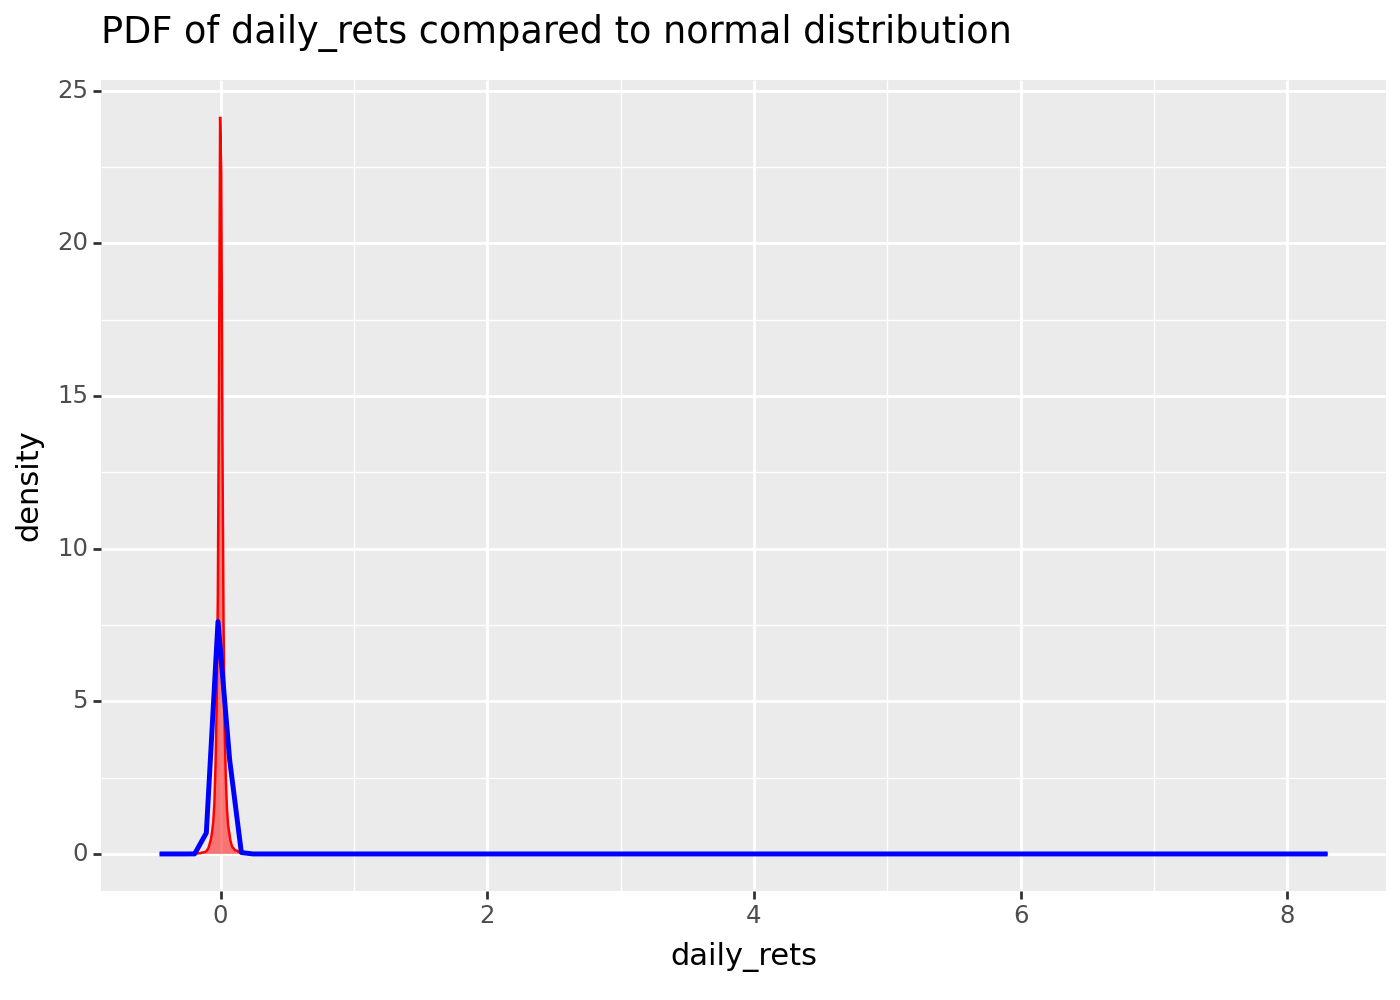

In [12]:
def plot_p9_pdf(data):
    column_name = data.columns[0]
    mean = data.mean().iloc[0]
    std = data.std().iloc[0]

    pdf_plot = (
        ggplot(data, aes(x=column_name)) +
        geom_density(color='red', fill='red', alpha=0.5) +
        stat_function(
            fun=norm.pdf,
            args=(mean, std),
            color='blue',
            size=1
        ) +
        ggtitle(f'PDF of {column_name} compared to normal distribution') +
        theme(figure_size=(7, 5))
    )

    print(pdf_plot)

daily_rets = top_eod_data['daily_rets']
daily_rets = daily_rets.sample(60_000)
daily_rets = daily_rets.to_frame()
plot_p9_pdf(daily_rets)

#### **WRDS Market Data Bars (WRDS TAQ)**

WRDS TAQ has millisecond-level best bid and offer data.  However, downloading the full data series is not practical due to the hundreds of millions of rows per day.  Here, we use SQL to generate more manageable "bars" on the server side.

We would like to incorporate this data over relying on EOD price data, however, due to our strategy we would need to pull an extremely large amount of data and this query is not time efficient. However, we still include below to review the data robustness. 

From our review below we found for a single day the data had limited nan price values (limited to a handful of stocks) and the return values were within reasonable limits without significant outliers. As a result, if we can find an efficient way to integrate this data we will in future analysis.

In [18]:
@lru_cache
def taq_nbbo_bars_on_date(tickers: list[str] | str, date:datetime.date, bar_minutes=30):
    assert bar_minutes==60 or (bar_minutes<=30 and 30%bar_minutes==0)
    date_str = date.strftime('%Y%m%d')
    year_str = date.strftime('%Y')
    tickers = (tickers,) if hasattr(tickers,'strip') else tuple(tickers)  # Allow single ticker as argument

    sql = f"""
            WITH windowable_nbbo AS (
                SELECT
                    sym_root AS ticker
                    , date
                    , time_m
                    , time_m_nano
                    , sym_root
                    , qu_cond
                    , best_bid
                    , best_bidsizeshares
                    , best_ask
                    , best_asksizeshares
                    , EXTRACT(HOUR FROM time_m) AS hour_of_day
                    , {bar_minutes} * DIV(EXTRACT(MINUTE FROM time_m),{bar_minutes}) AS minute_of_hour
                    , ROW_NUMBER() OVER (PARTITION BY sym_root, EXTRACT(HOUR FROM time_m), DIV(EXTRACT(MINUTE FROM time_m),{bar_minutes}) ORDER BY time_m DESC) AS rownum
                FROM taqm_{year_str}.complete_nbbo_{date_str} 
                WHERE 1=1
                  AND sym_root IN {tickers}
                  AND sym_suffix IS NULL
                  AND time_m > '09:30:00' AND time_m < '16:00:00'
            )
            SELECT DISTINCT ON (ticker, date, hour_of_day, minute_of_hour)
                ticker
                , date
                , date + (hour_of_day || ':' || minute_of_hour)::interval + ( '00:{bar_minutes}' )::interval AS window_time
                , best_bid
                , best_bidsizeshares
                , best_ask
                , best_asksizeshares
                , time_m AS time_of_last_quote
                , time_m_nano AS time_of_last_quote_ns
            FROM windowable_nbbo
            WHERE windowable_nbbo.rownum = 1
            """
    bars = db.raw_sql(sql)
    
    def _make_timestamp(r):
        t = datetime.datetime.combine(r.date, r.time_of_last_quote)#, tzinfo=pytz.timezone('America/New_York'))
        pdt = pd.to_datetime(t).tz_localize(pytz.timezone('America/New_York')) + pd.Timedelta(r.time_of_last_quote_ns, unit="ns")
        return pdt
    bars['time_of_last_quote'] = bars.apply(_make_timestamp, axis=1)
    del bars['time_of_last_quote_ns']
    bars['window_time'] = pd.to_datetime(bars['window_time']).dt.tz_localize(pytz.timezone('America/New_York'))
    return bars

,best_bid,best_bidsizeshares,best_ask,best_asksizeshares
count,36495.000000,36495.000000,36493.000000,36493.000000
mean,75.006413,2252.801754,75.137007,2215.761927
std,134.326341,12102.500494,134.658795,11490.116987
min,0.138000,100.000000,0.143100,100.000000
25%,14.890000,200.000000,14.930000,200.000000
50%,35.350000,400.000000,35.390000,400.000000
75%,83.045000,700.000000,83.170000,700.000000
max,7640.010000,608100.000000,7640.310000,455600.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36631 entries, 0 to 36630
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype                           
---  ------              --------------  -----                           
 0   ticker              36631 non-null  object                          
 1   date                36631 non-null  object                          
 2   window_time         36631 non-null  datetime64[ns, America/New_York]
 3   best_bid            36495 non-null  float64                         
 4   best_bidsizeshares  36495 non-null  float64                         
 5   best_ask            36493 non-null  float64                         
 6   best_asksizeshares  36493 non-null  float64                         
 7   time_of_last_quote  36631 non-null  datetime64[ns, America/New_York]
 8   datetime            36631 non-null  datetime64[ns, America/New_York]
dtypes: datetime64[ns, America/New_York](3), float64(4), object(2)
memory usag

None

ticker
AZO     11
BH       1
BKNG    11
CABO     1
CACC     1
CACI     1
CMG     10
COKE     3
CRVL     3
DJCO    10
ESGR     1
FICO     2
GHC      8
HIFS     6
MELI     3
MTD      3
NEU      1
NVR      8
ORLY     1
SEB     10
TDG      1
TPL     13
UFPT     1
USLM     2
VRTS     1
WINA    11
WTM     12
dtype: int64

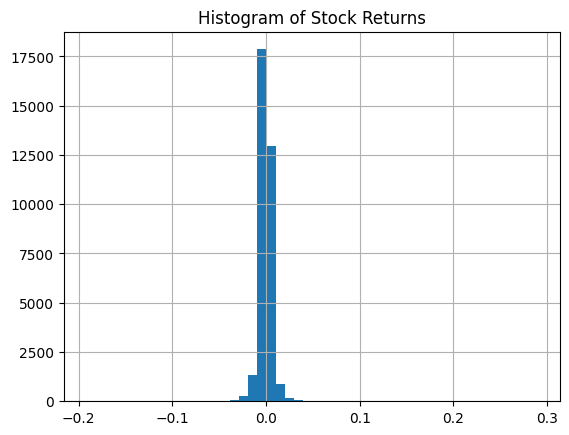

In [ ]:
b20240229 = taq_nbbo_bars_on_date(top_tickers, date=datetime.date(2024,2,29))
b20240229['datetime'] = pd.to_datetime(b20240229['window_time'])
b20240229 = b20240229.sort_values(by=['ticker','datetime'],ascending=True)

display(b20240229.describe())
display(b20240229.info())

display(b20240229.loc[b20240229.best_bid.isna()].groupby(['ticker']).size())

b20240229['returns'] = b20240229.groupby('ticker')['best_bid'].pct_change()
b20240229['returns'].hist(bins=50)
plt.title("Histogram of Stock Returns")
plt.show()

#### **WRDS I/B/E/S Summary History**

​Refinitiv's Institutional Brokers' Estimate System (I/B/E/S) offers a comprehensive database of analyst forecasts and actual earnings data for publicly traded companies worldwide. The "Surprise History" within I/B/E/S specifically focuses on earnings surprises, providing insights into how actual earnings compare to analyst expectations over time.

Key components of the I/B/E/S Surprise History data include:
- Analyst Estimates: Forecasts for various financial metrics, notably Earnings Per Share (EPS), collected from a vast network of analysts. These estimates are aggregated to form consensus figures, serving as benchmarks for actual performance.​
- Actual Reported Earnings: The realized financial figures reported by companies, allowing for direct comparison against prior analyst projections.​




In [77]:
start_filing_date = '2014-01-01'
end_filing_date = '2024-12-31'

query_ibes = f"""
    SELECT 
        *
    FROM 
        tr_ibes.surpsum
    WHERE
        1=1
        AND pyear>=2014
        AND fiscalp='QTR'
        AND measure='EPS'
        AND oftic IS NOT NULL
        AND anndats >= '{start_filing_date}'
        AND anndats <= '{end_filing_date}'
"""
surp_sum = db.raw_sql(query_ibes)

display(surp_sum.head())
display(surp_sum.tail())
display(surp_sum.describe())

,ticker,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore
0,0000,TLMR,EPS,QTR,2014.0,3.0,1,2014-05-06,0.12,0.08000,0.01414,2.82845
1,0000,TLMR,EPS,QTR,2014.0,6.0,1,2014-08-06,0.27,0.13000,0.01225,11.43137
2,0000,TLMR,EPS,QTR,2014.0,9.0,1,2014-11-04,0.26,0.23200,0.05848,0.47879
3,0000,TLMR,EPS,QTR,2014.0,12.0,1,2015-01-30,0.16,0.17167,0.01169,-0.99800
4,0000,TLMR,EPS,QTR,2015.0,3.0,1,2015-04-30,0.12,0.17833,0.01835,-3.17927


,ticker,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore
366971,ZZZ,ZZZ,EPS,QTR,2023.0,6.0,0,2023-08-10,0.42,0.48333,0.01966,-3.22078
366972,ZZZ,ZZZ,EPS,QTR,2023.0,9.0,0,2023-11-09,0.76,0.77000,0.07563,-0.13222
366973,ZZZ,ZZZ,EPS,QTR,2023.0,12.0,0,2024-03-06,0.56,0.52500,0.02074,1.68789
366974,ZZZ,ZZZ,EPS,QTR,2024.0,3.0,0,2024-05-07,0.28,0.35833,0.03430,-2.28357
366975,ZZZ,ZZZ,EPS,QTR,2024.0,6.0,0,2024-08-08,0.54,0.35500,0.05323,3.47555


,pyear,pmon,usfirm,actual,surpmean,surpstdev,suescore
count,366976.000000,366976.000000,366976.000000,3.605360e+05,3.669760e+05,2.645590e+05,256975.000000
mean,2018.999741,7.348102,0.502115,-1.313972e+05,-3.481676e+05,4.029730e+03,0.845682
std,3.099435,3.337119,0.499996,4.099740e+07,1.377658e+08,1.089106e+06,90.074564
min,2014.000000,1.000000,0.000000,-1.915200e+10,-6.048000e+10,0.000000e+00,-10010.134340
25%,2016.000000,3.000000,0.000000,0.000000e+00,1.500000e-02,1.940000e-02,-0.942820
50%,2019.000000,6.000000,1.000000,3.100000e-01,3.100000e-01,4.950000e-02,0.409390
75%,2022.000000,9.000000,1.000000,1.123237e+00,1.106000e+00,1.595300e-01,2.000000
max,2024.000000,12.000000,1.000000,2.475000e+05,2.100000e+05,4.725256e+08,25909.274190


Below we found the suescore is centered around a mean of zero with extreme outliers in a range of -10,000 to 25,000. Going forward we will continue to filter this dataset and will need to handle for outliers when conducting our analysis as extreme unexpected earnings numbers will impact our trading.

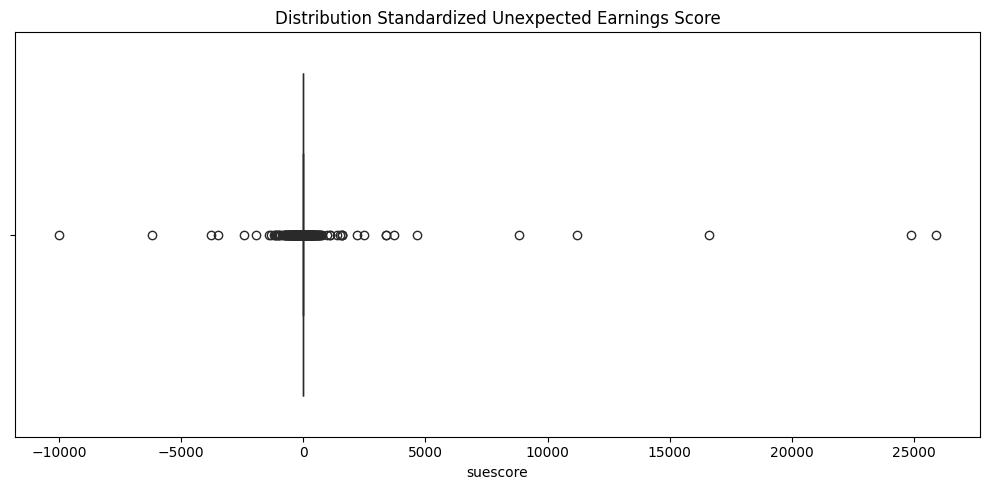

In [78]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=surp_sum['suescore'], orient='h', color='darkred')
ax.set_title('Distribution Standardized Unexpected Earnings Score')
plt.tight_layout()
plt.show()

#### **Fama-French Factor Returns**

We obtained the Fama-French factor returns (SMB, HML, RF and Mkt-RF) over the same data period as trading period (reference https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).

In [8]:
ff_file_path = rf"../data/F-F_Research_Data_Factors_daily.csv"
ff_data = pd.read_csv(ff_file_path)
ff_data['date'] = pd.to_datetime(ff_data['date'], format='%Y%m%d')

display(ff_data.head())
display(ff_data.tail())

,date,Mkt-RF,SMB,HML,RF
0,1926-07-01,0.10,-0.25,-0.27,0.009
1,1926-07-02,0.45,-0.33,-0.06,0.009
2,1926-07-06,0.17,0.30,-0.39,0.009
3,1926-07-07,0.09,-0.58,0.02,0.009
4,1926-07-08,0.21,-0.38,0.19,0.009


,date,Mkt-RF,SMB,HML,RF
25875,2024-11-22,0.54,1.25,0.41,0.02
25876,2024-11-25,0.40,1.07,0.27,0.02
25877,2024-11-26,0.42,-0.92,-0.71,0.02
25878,2024-11-27,-0.39,0.28,0.47,0.02
25879,2024-11-29,0.54,0.14,-0.64,0.02


### Data Cleansing/Merge

#### Earnings Surprise Data
Below we are: 
- Converting "anndats" to a proper datetime, dropping any rows where it’s missing.
- Extracting the year from each announcement date, which we will use as a proxy for determining which data is consistent throughout.
- Filtering to keep only tickers that appear in every year of our date range   (year_beginning_filter through year_end_filter).
- Further ensuring each ticker has 4 quarters of data each year for consistently quarterly coverage.
- Removing any ticker that fails these conditions, leaving a final set of tickers meeting both the year coverage and 4-quarter criteria.
- Printing out the number of Investable universe of stocks for this dataset

In [91]:
# Cleaning the surprise Data
surp_sum['anndats'] = pd.to_datetime(surp_sum['anndats'], errors='coerce')
surp_sum = surp_sum[surp_sum['anndats'].notnull()]

surp_sum['year'] = surp_sum['anndats'].dt.year

years_required = set(range(year_beginning_filter, year_end_filter+1))

coverage = surp_sum.groupby('oftic')['year'].apply(set)
keep_tickers = coverage[coverage.apply(lambda x: years_required.issubset(x))].index
surp_sum = surp_sum[surp_sum['oftic'].isin(keep_tickers)]

quarter_counts = (
    surp_sum
    .groupby(['oftic', 'year'])
    .size()
    .reset_index(name='count_per_year')
)

quarter_counts_ok = quarter_counts[quarter_counts['count_per_year'] >= 4]

annual_coverage = quarter_counts_ok.groupby('oftic')['year'].apply(set)
keep_tickers_4q = annual_coverage[annual_coverage.apply(lambda x: years_required.issubset(x))].index

# Filtering out stocks that dont have 4 quarters of data for each year
surp_sum = surp_sum[surp_sum['oftic'].isin(keep_tickers_4q)]
surp_sum['oftic'].nunique()

3632

##### Integrating Zack's Fundamental B Dataset
Below we are:
- Setting a market value threshold of $500 million to ensure our data stays above that amount throughout the entire date range.
- Calculating new metrics for use in rankings, P/E, EV/EBITDA, and YoY growth in revenue and price
- Ensuring we have consistent quarterly data for all the metrics below
- Printing out the unique amount of filters that pass these filters.
- We then filter the remaining tickers on what we have in the filtered surprise dataset to end up with 327 individual stocks that pass our criteria

In [92]:
# Setting The Market Cap Threshold to Filter out Smaller Companies
mkt_cap_threshold = 500

# Selecting the metrics we plan to include in our strategy
zacks_df = zacks_df.copy()
zacks_df = zacks_df[zacks_df['per_end_date'].notnull() & (zacks_df['per_type'] == 'Q')]
zacks_df.dropna(subset=['tot_revnu','ebitda','eps_basic_net','mkt_val','ep_val','shares_out'], inplace=True)
zacks_df.sort_values(['ticker','per_end_date'], inplace=True)

# Creating Other metrics we plan to use as indicators
zacks_df = zacks_df[zacks_df['per_end_date'].between(start_filing_date, end_filing_date)]
zacks_df['price'] = zacks_df['mkt_val'] / zacks_df['shares_out']
zacks_df['PE'] = zacks_df['price'] / zacks_df['eps_basic_net']
zacks_df['EV_EBITDA'] = zacks_df['ep_val'] / zacks_df['ebitda']
zacks_df['rev_yoy_growth'] = zacks_df.groupby('ticker')['tot_revnu'].pct_change(periods=4)
zacks_df['price_yoy_growth'] = zacks_df.groupby('ticker')['price'].pct_change(periods=4)

# Filtering Stocks to a smaller date range
zacks_df = zacks_df[zacks_df['per_end_date'].between(start_filter_date, end_filter_date)]
zacks_df['year'] = zacks_df['per_end_date'].dt.year

# Filtering out stocks with Market Cap below the threshold
min_cap_by_ticker = zacks_df.groupby('ticker')['mkt_val'].transform('min')
zacks_df = zacks_df[min_cap_by_ticker >= mkt_cap_threshold]

years_required = set(range(year_beginning_filter, year_end_filter + 1))
coverage = zacks_df.groupby('ticker')['year'].apply(set)
keep_tickers = coverage[coverage.apply(lambda s: years_required.issubset(s))].index
zacks_df = zacks_df[zacks_df['ticker'].isin(keep_tickers)]

counts = zacks_df.groupby(['ticker', 'year']).size().reset_index(name='count_per_year')
counts_ok = counts[counts['count_per_year'] >= 4]
annual_coverage = counts_ok.groupby('ticker')['year'].apply(set)
keep_tickers_4q = annual_coverage[annual_coverage.apply(lambda s: years_required.issubset(s))].index
zacks_df = zacks_df[zacks_df['ticker'].isin(keep_tickers_4q)]
zacks_df['ticker'].nunique()

372

In [93]:
# Filtering the surprise data on market cap requirement
valid_tickers = set(zacks_df['ticker'].unique())
surp_sum_filtered = surp_sum[surp_sum['oftic'].isin(valid_tickers)]
surp_sum_filtered['oftic'].nunique()

surp_sum_filtered.head()

,ticker,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year
266,001J,KN,EPS,QTR,2014.0,3.0,1,2014-04-28,0.32,0.30333,0.01155,1.44338,2014
267,001J,KN,EPS,QTR,2014.0,6.0,1,2014-07-28,0.21,0.17600,0.00894,3.80143,2014
268,001J,KN,EPS,QTR,2014.0,9.0,1,2014-10-27,0.38,0.40500,0.05505,-0.45417,2014
269,001J,KN,EPS,QTR,2014.0,12.0,1,2015-02-12,0.14,0.34125,0.02232,-9.01617,2015
270,001J,KN,EPS,QTR,2015.0,3.0,1,2015-04-23,0.06,0.02750,0.01832,1.77373,2015


##### Transforming the primary final dataset
Below we are:
- Assign tickers to bins based on their avg_EPS to ensure we are comparing similar magnitudes of percent changes.
- We then transform the daily stock data obtained from the 'QUOTEMEDIA/PRICES' dataset to obtain the next day adjusted close and compute the return between those two days to capture the initial movement of the earnings surprise
- We merge these two datasets and bring in the relevant columns.
- The avg_eps_estimate is then calculated from subtracting the surprise mean from the actual EPS.
- Pct_surprise is calculated as the (average surprise)/ (the next day return)
- We then calculate the primary metric 'surprise_vs_move' which is simply the pct_surprise/(next day return). This should help us gauge how much the stock moved relative to it's surprise number
- The data is then translated into a z-score subtracting the mean of the bin it is in as well as dividing by the standard deviation of the same bin.

In [94]:
# Separating the Surprises into Bins
surp_sum_filtered['avg_eps'] = surp_sum_filtered.groupby('ticker')['actual'].transform('mean')
bins = [-np.inf, 0, 0.5, 1, 2,  np.inf]
labels = [
    "Negative",
    "0 to 0.5",
    "0.5 to 1.0",
    "1.0 to 2.0",
    ">2.0"
]

surp_sum_filtered['avg_eps_bin'] = pd.cut(surp_sum_filtered['avg_eps'], bins=bins, labels=labels)


surp_sum_filtered.groupby('avg_eps_bin')['ticker'].nunique()

avg_eps_bin
Negative       31
0 to 0.5      127
0.5 to 1.0    121
1.0 to 2.0     84
>2.0           45
Name: ticker, dtype: int64

In [95]:
# Sorting close prices for merge
eod_data = top_eod_data.copy()

# Creating the next day close price and next day return
eod_data['next_close'] = eod_data.groupby('ticker')['adj_close'].shift(-1)
eod_data['next_day_return'] = (
    eod_data['next_close'] / eod_data['adj_close'] - 1
)

eod_data['next_close_20'] = eod_data.groupby('ticker')['adj_close'].shift(-20)
eod_data['next_20day_return'] = (
    eod_data['next_close_20'] / eod_data['adj_close'] - 1
)

eod_data['date'] = pd.to_datetime(eod_data['date'])
surp_sum_filtered['anndats'] = pd.to_datetime(surp_sum_filtered['anndats'])

surp_sum_filtered.drop(['ticker'], axis=1, inplace=True)

# Merging the surprise data with the EOD data
surp_sum_merged = surp_sum_filtered.merge(
    eod_data[['ticker','date','adj_close','next_close','next_day_return','next_close_20','next_20day_return']],
    how='left',
    left_on=['oftic','anndats'],
    right_on=['ticker','date']
)

surp_sum_merged.head()

,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,avg_eps,avg_eps_bin,ticker,date,adj_close,next_close,next_day_return,next_close_20,next_20day_return
0,KN,EPS,QTR,2014.0,3.0,1,2014-04-28,0.32,0.30333,0.01155,1.44338,2014,0.243571,0 to 0.5,KN,2014-04-28,30.92,29.52,-0.045278,28.16,-0.089263
1,KN,EPS,QTR,2014.0,6.0,1,2014-07-28,0.21,0.17600,0.00894,3.80143,2014,0.243571,0 to 0.5,KN,2014-07-28,29.08,28.69,-0.013411,32.61,0.121389
2,KN,EPS,QTR,2014.0,9.0,1,2014-10-27,0.38,0.40500,0.05505,-0.45417,2014,0.243571,0 to 0.5,KN,2014-10-27,18.80,19.40,0.031915,20.97,0.115426
3,KN,EPS,QTR,2014.0,12.0,1,2015-02-12,0.14,0.34125,0.02232,-9.01617,2015,0.243571,0 to 0.5,KN,2015-02-12,21.64,18.59,-0.140943,20.29,-0.062384
4,KN,EPS,QTR,2015.0,3.0,1,2015-04-23,0.06,0.02750,0.01832,1.77373,2015,0.243571,0 to 0.5,KN,2015-04-23,21.24,20.08,-0.054614,19.37,-0.088041


In [96]:
# Calculating avg_estimate
surp_sum_merged['eps_estimate'] = surp_sum_merged['actual'] - surp_sum_merged['surpmean']

# Calculating percent surprise
surp_sum_merged['pct_surprise'] = (
    surp_sum_merged['surpmean'] / surp_sum_merged['eps_estimate']
)

# Creating a metric to estimate the drift available
surp_sum_merged['surprise_vs_move'] = (
    surp_sum_merged['pct_surprise'] / surp_sum_merged['next_day_return']
)
surp_sum_merged['surprise_vs_move'] = surp_sum_merged['surprise_vs_move'].replace([np.inf, -np.inf], 0)

surp_sum_merged['zscore_surprise_vs_move'] = (
    surp_sum_merged
    .groupby('avg_eps_bin')['surprise_vs_move']
    .transform(lambda x: (x - x.mean()) / x.std())
)
surp_sum_merged.head()

,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,avg_eps,avg_eps_bin,ticker,date,adj_close,next_close,next_day_return,next_close_20,next_20day_return,eps_estimate,pct_surprise,surprise_vs_move,zscore_surprise_vs_move
0,KN,EPS,QTR,2014.0,3.0,1,2014-04-28,0.32,0.30333,0.01155,1.44338,2014,0.243571,0 to 0.5,KN,2014-04-28,30.92,29.52,-0.045278,28.16,-0.089263,0.01667,18.196161,-401.875208,-0.018734
1,KN,EPS,QTR,2014.0,6.0,1,2014-07-28,0.21,0.17600,0.00894,3.80143,2014,0.243571,0 to 0.5,KN,2014-07-28,29.08,28.69,-0.013411,32.61,0.121389,0.03400,5.176471,-385.978884,-0.018337
2,KN,EPS,QTR,2014.0,9.0,1,2014-10-27,0.38,0.40500,0.05505,-0.45417,2014,0.243571,0 to 0.5,KN,2014-10-27,18.80,19.40,0.031915,20.97,0.115426,-0.02500,-16.200000,-507.600000,-0.021374
3,KN,EPS,QTR,2014.0,12.0,1,2015-02-12,0.14,0.34125,0.02232,-9.01617,2015,0.243571,0 to 0.5,KN,2015-02-12,21.64,18.59,-0.140943,20.29,-0.062384,-0.20125,-1.695652,12.030791,-0.008396
4,KN,EPS,QTR,2015.0,3.0,1,2015-04-23,0.06,0.02750,0.01832,1.77373,2015,0.243571,0 to 0.5,KN,2015-04-23,21.24,20.08,-0.054614,19.37,-0.088041,0.03250,0.846154,-15.493369,-0.009083


In [ ]:
# surp_sum_merged.to_parquet('../data/surp_sum_merged.parquet')
# surp_sum_merged = pd.read_parquet('../data/surp_sum_merged.parquet')

##### Merging the Fundamentals and Surprise Data
Below we are:
- Transforming the fundamental data and Earnings Surprise to ensure that we have a latest date for both to avoid lookahead bias in trades. To be safe we assume we are only available to trade on this information after the announcement and filing date.
- Both of the datasets are then merged on 'ticker' and 'oftic'.
- Trade day is then calculated as the latest day between the two announcements
- Calculate Z_scores for new metrics within bins
- We then drop incomplete rows and features for a final cleanup.

In [97]:
zacks_df['valid_from'] = zacks_df['filing_date'] + pd.Timedelta(days=1)
fund_cols = [
    'ticker','per_end_date','filing_date','valid_from','PE','EV_EBITDA',
    'rev_yoy_growth','price_yoy_growth','price','mkt_val'
]
fund_data = zacks_df[fund_cols].copy()

surp_data = surp_sum_merged.copy()
surp_data['announcement_plus_1'] = surp_data['anndats'] + pd.Timedelta(days=1)

# Storing columns we need analysis
surp_cols = [
    'oftic','anndats','announcement_plus_1','pct_surprise','suescore',
    'eps_estimate','avg_eps_bin','zscore_surprise_vs_move'
]
surp_data = surp_data[surp_cols].copy()
surp_data = surp_data.rename(columns={'oftic': 'ticker'})
surp_data_sorted = surp_data.sort_values(by="announcement_plus_1")
fund_data_sorted = fund_data.sort_values(by="valid_from")

merged = pd.merge_asof(
    left=surp_data_sorted,
    right=fund_data_sorted,
    left_on="announcement_plus_1",
    right_on="valid_from",
    by="ticker",            
    direction="backward"    
)

# Calculating the trade day as the later of the two dates.
merged['trade_day'] = merged[['valid_from','announcement_plus_1']].max(axis=1)

# Dropping rows that did not find a matching filing date
surp_final = merged.dropna(subset=['filing_date'])
surp_final.head()


,ticker,anndats,announcement_plus_1,pct_surprise,suescore,eps_estimate,avg_eps_bin,zscore_surprise_vs_move,per_end_date,filing_date,valid_from,PE,EV_EBITDA,rev_yoy_growth,price_yoy_growth,price,mkt_val,trade_day
6743,TEL,2019-04-30,2019-05-01,2.669516,6.91746,0.87750,>2.0,0.034622,2019-03-31,2019-04-27,2019-04-28,62.114648,42.684111,-0.042111,-0.191699,80.749043,27201.93,2019-05-01
6748,L,2019-05-01,2019-05-02,-47.987952,-0.52966,-0.01660,1.0 to 2.0,0.073637,2019-03-31,2019-04-30,2019-05-01,37.739905,32.382558,0.049148,-0.036208,47.929680,14613.28,2019-05-02
6820,TEVA,2019-05-03,2019-05-04,29.226700,0.52967,0.01985,0.5 to 1.0,-0.015897,2019-03-31,2019-05-03,2019-05-04,-156.800016,68.987314,-0.180849,-0.082504,15.680002,15944.68,2019-05-04
6823,CL,2019-05-06,2019-05-07,-0.044229,-15.98799,-0.15171,Negative,-0.029790,2019-03-31,2019-04-27,2019-04-28,105.445543,64.205184,-0.029485,-0.043812,68.539603,58842.62,2019-05-07
6830,TNET,2019-05-06,2019-05-07,inf,NaN,0.00000,0.5 to 1.0,-0.004858,2019-03-31,2019-04-30,2019-05-01,65.649881,35.373000,0.084785,0.289684,59.741392,4181.30,2019-05-07


In [98]:
# Identifying tickers that have missing rev_yoy_growth or price_yoy_growth
tickers_with_na = (
    surp_final
    .loc[surp_final[['rev_yoy_growth','price_yoy_growth']].isna().any(axis=1), 'ticker']
    .unique()
)

# Dropping all rows belonging to these tickers
surp_final = surp_final[~surp_final['ticker'].isin(tickers_with_na)]
surp_final['ticker'].nunique()

315

In [100]:
# List of fundamental metrics to compute z-scores for, by avg_eps_bin
fund_metrics = ['EV_EBITDA', 'rev_yoy_growth', 'price_yoy_growth', 'price', 'mkt_val']

for metric in fund_metrics:
    surp_final[metric + '_bin_z'] = surp_final.groupby('avg_eps_bin')[metric].transform(
        lambda x: (x - x.mean()) / x.std()
    )

surp_final.tail()

,ticker,anndats,announcement_plus_1,pct_surprise,suescore,eps_estimate,avg_eps_bin,zscore_surprise_vs_move,per_end_date,filing_date,valid_from,PE,EV_EBITDA,rev_yoy_growth,price_yoy_growth,price,mkt_val,trade_day,EV_EBITDA_bin_z,rev_yoy_growth_bin_z,price_yoy_growth_bin_z,price_bin_z,mkt_val_bin_z
14776,POST,2024-11-14,2024-11-15,4.143895,3.72131,0.29744,0.5 to 1.0,-0.006823,2024-06-30,2024-08-03,2024-08-04,62.744320,37.480117,0.047488,0.202024,104.155571,6085.81,2024-11-15,-0.083631,-0.063028,0.210412,0.505061,-0.217673
14777,DIS,2024-11-14,2024-11-15,28.749478,0.78360,0.03832,1.0 to 2.0,0.018486,2024-06-30,2024-08-08,2024-08-09,68.951393,47.671804,0.036946,0.112119,99.290005,184480.83,2024-11-15,-0.020714,-0.150220,-0.093590,-0.263362,0.501730
14778,ESE,2024-11-14,2024-11-15,57.400000,1.05020,0.02500,0.5 to 1.0,0.008627,2024-06-30,2024-08-10,2024-08-11,92.144098,51.707646,0.048378,0.013723,105.044272,2704.89,2024-11-15,-0.033711,-0.061021,-0.279824,0.521289,-0.229760
14779,EFX,2024-11-14,2024-11-15,0.248092,3.13897,0.26200,0 to 0.5,-0.008813,2024-09-30,2024-10-22,2024-10-23,257.776126,96.735886,0.093018,0.604282,293.864784,36424.54,2024-11-15,0.014363,0.006283,0.837427,3.952586,0.010489
14780,DTE,2024-11-14,2024-11-15,-43.727273,-0.45992,-0.01100,0 to 0.5,-0.200484,2024-09-30,2024-10-25,2024-10-26,55.830601,46.252870,0.006233,0.293424,128.410381,26593.79,2024-11-15,0.007071,-0.102623,0.274696,1.235771,-0.052649


In [73]:
print(surp_final.isna().sum())

ticker                     0
anndats                    0
announcement_plus_1        0
pct_surprise               0
suescore                   0
eps_estimate               0
avg_eps_bin                0
zscore_surprise_vs_move    0
per_end_date               0
filing_date                0
valid_from                 0
PE                         0
EV_EBITDA                  0
rev_yoy_growth             0
price_yoy_growth           0
price                      0
mkt_val                    0
trade_day                  0
EV_EBITDA_bin_z            0
rev_yoy_growth_bin_z       0
price_yoy_growth_bin_z     0
price_bin_z                0
mkt_val_bin_z              0
dtype: int64


## **Data Analysis** (To be extended in next phase)

Below highlights the distribution of Standardize Unexpected Earnings and the Z-score Suprise vs Price Move metric we created for our filtered final dataset. 

We can see it is highly concentrated around zero with the presence of extreme outliers (we did drop the very large outliers from the original dataset). The outliers are on both sides extending far beyond the whiskers (values exceeding +-100). This suggests the high kurtosis. 

As we develop our strategy we may consider capping extreme values (eg at the 1st and 99th percentile) to prevent large outliers from skewing analysis.Additionally, we will check for data errors to verify whether extreme values are genuine earning surprises or potential data errors. 

It is important to handle these outliers because of the potential impact on trading. If extreme SUE values do not consistently translate to price movements, filtering extreme values may improve signal reliability.

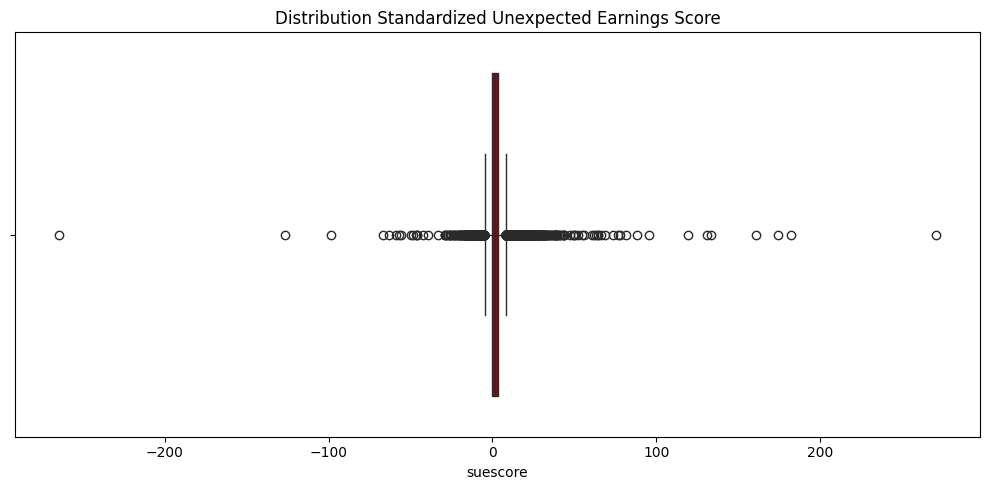

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=surp_sum_merged['suescore'], orient='h', color='darkred')
ax.set_title('Distribution Standardized Unexpected Earnings Score')
plt.tight_layout()
plt.show()

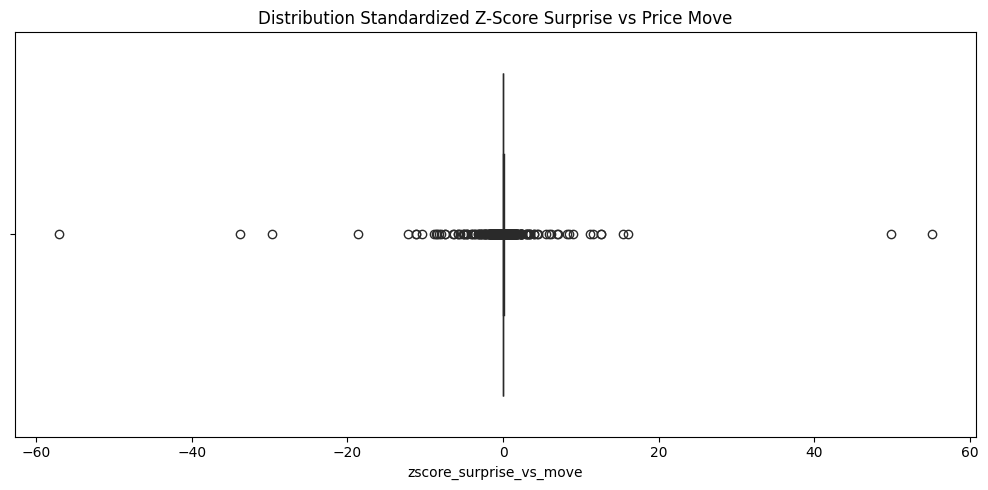

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=surp_sum_merged['zscore_surprise_vs_move'], orient='h', color='darkred')
ax.set_title('Distribution Standardized Z-Score Surprise vs Price Move')
plt.tight_layout()
plt.show()

The facet grid below shows the distribution of z-score of `Surprise vs Price Move" across different bins of average EPS values. Each subplot corresponds to a different bin of average EPS (Negative, 0-0.5, 0.5-1.0, 1.0-2.0, >2.0).

The distribution across all bins are highly centered around zero. This suggests that the price reaction is relatively proportional to the earnings surprises and next-day price moves are rare.

There are a few occurrances of extreme negative and positive values in the z-score distribution. This implies that in some instances, the market underreacts or overreacts significantly to earnings surprises.

The pattern is consistent across different EPS size bins. Regardless of whether the average EPS value is negative, small, or large most observations show only small deviations in price move relative to the earnings surprise.

Since the most values cluster around zero, it may be beneficial for us to focus on stocks where the z-score is highly negative (indicating a significant underreaction to earnings surprises). As mentioned before, the presences of extreme values suggests that data filtering may improve the robustness of our trading strategy. Lastly, the relatively similar distributions across different EPS bins indicate that earnings size alone does not drastically change the reaction pattern, which suggests that ranking based on z-score deviation remains a strong method for trade selection.

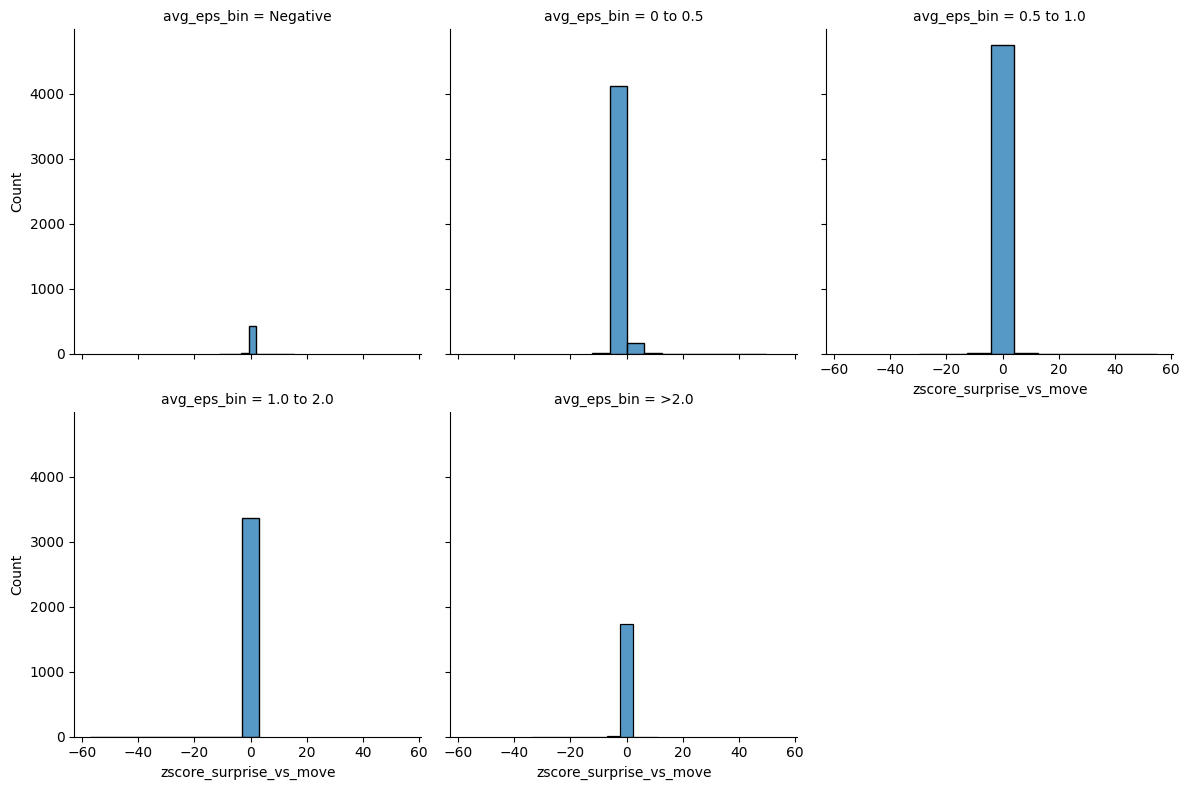

In [14]:
g = sns.FacetGrid(surp_sum_merged, col="avg_eps_bin", col_wrap=3, height=4)
g.map(sns.histplot, "zscore_surprise_vs_move", bins=10)
plt.show()

Our strategy is based on market reaction to earnings releases, so below we show the relationship between SUE score and next price change and a 20 day price change lag. Both plots below so the relationship between the Standardize Unexpected Earnings (SUE) Score and stock returns over the different time horizons (1 day vs 20 day), categorized by average EPS bins. 

Key observations for 1-Day Return vs SUE Score:
- Weak Positive Relationship: There appears to be a weak positive correlation between the SUE score and next-day return, meaning that stocks with higher earnings surprises tend to have slightly higher immediate returns.
-  High Dispersion: The returns are widely dispersed, suggesting that while some stocks react predictably to earnings surprises, many do not follow a clear trend.
- Limited Underreaction Evidence: The concentration of data points around SUE = 0 and returns near 0 suggests that many stocks may have already absorbed much of the surprise in the immediate reaction.

Key observations for 20-Day Return vs SUE Score:
- Greater Dispersion Over Time: Compared to the first plot, the returns after 20 days are even more widely spread, indicating that longer-term price movements are less predictable than immediate reactions.
- Potential Post-Drift Capture: Unlike the first plot, there are more instances where higher SUE scores correspond with larger long-term returns, suggesting a delayed price adjustment (underreaction effect).
- More Extreme Returns: The range of T+20 returns is significantly wider than next-day returns, implying that while some earnings surprises correct quickly, others take longer to be fully priced in.

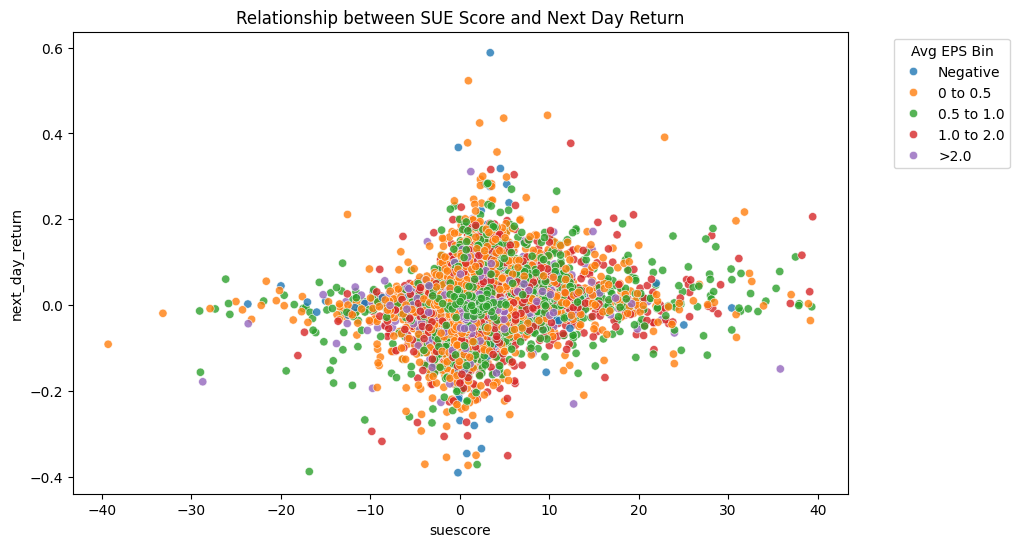

In [15]:
plt.figure(figsize=(10, 6))

plot_df = surp_sum_merged.loc[abs(surp_sum_merged['suescore'])<40].copy()

sns.scatterplot(
    x='suescore', 
    y='next_day_return', 
    hue='avg_eps_bin', 
    data=plot_df, 
    palette='tab10',
    alpha=0.8  
)

plt.xlabel('suescore')
plt.ylabel('next_day_return')
plt.title('Relationship between SUE Score and Next Day Return')

plt.legend(title='Avg EPS Bin', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

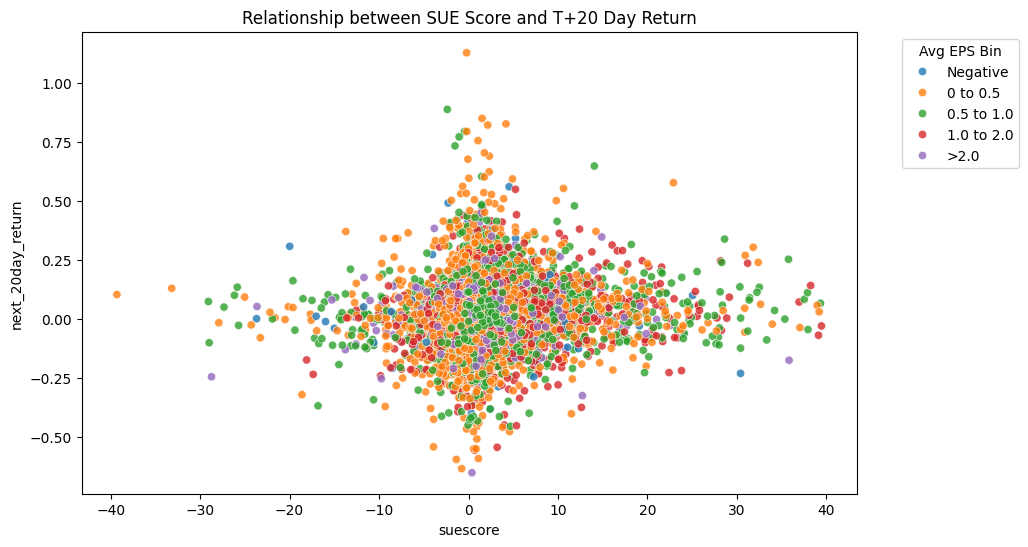

In [16]:
plt.figure(figsize=(10, 6))

plot_df = surp_sum_merged.loc[abs(surp_sum_merged['suescore'])<40].copy()

sns.scatterplot(
    x='suescore', 
    y='next_20day_return', 
    hue='avg_eps_bin', 
    data=plot_df, 
    palette='tab10',
    alpha=0.8  
)

plt.xlabel('suescore')
plt.ylabel('next_20day_return')
plt.title('Relationship between SUE Score and T+20 Day Return')

plt.legend(title='Avg EPS Bin', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

The heatmap below represents the correlation between earnings surprise vs. price move (z-score) and various fundamental metrics such as revenue growth, EV/EBITDA, and price growth.

No Strong Correlations (Close to Zero):
- The z-score of surprise vs. price move shows little to no correlation with revenue growth (rev_yoy_growth_bin_z), EV/EBITDA (EV_EBITDA_bin_z), and price growth (price_yoy_growth_bin_z).
- This suggests that earnings surprise reaction (price response) does not systematically align with fundamental indicators in a linear way.

Implications for our trading strategy:
- Since earnings surprise reaction does not correlate strongly with fundamental metrics, post-earnings drift strategies should prioritize price action signals over fundamental indicators. However, combining earnings surprise signals with price momentum factors might improve predictive power of our model.
- The weak correlation (0.15) between revenue growth and price performance suggests that revenue expansion may play a small role in driving stock returns.

Future Analysis:
- We will test interactions between earnings surprise and price momentum factors (eg past 10-day or 20-day returns) to see if momentum amplifies post-earnings drift.
- Examine sector-based correlations to determine if certain industries exhibit stronger relationships between earnings surprises and fundamental performance.

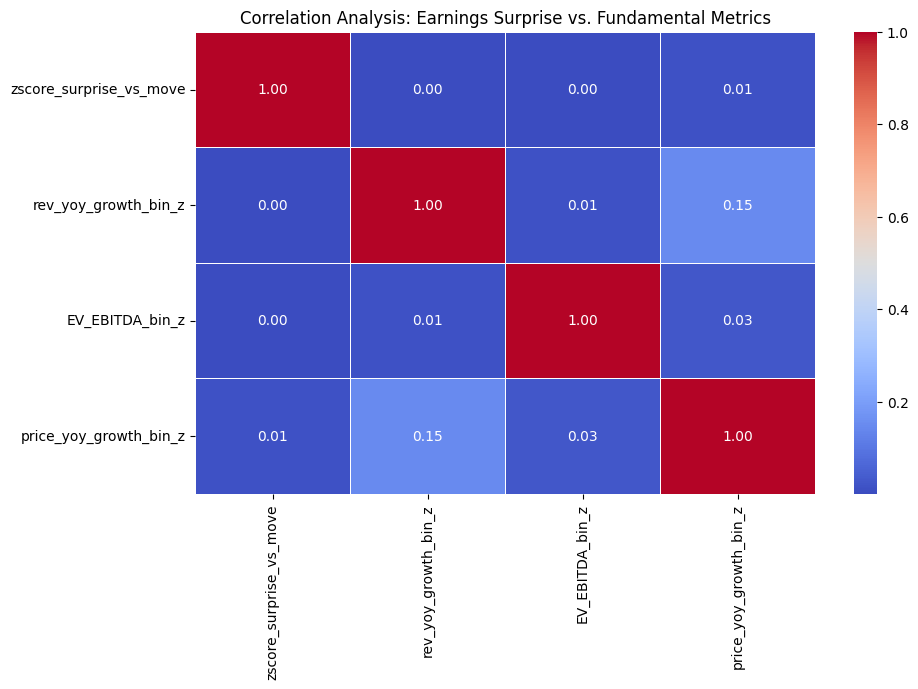

In [58]:
corr_matrix = surp_final[['zscore_surprise_vs_move', 'rev_yoy_growth_bin_z','EV_EBITDA_bin_z','price_yoy_growth_bin_z']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Analysis: Earnings Surprise vs. Fundamental Metrics")
plt.show()

# NEXT PHASE

## **Strategy Implementation**

## **Backtesting**

## **Performance Analysis**

## **References**